# 単変量回帰
## 欠損値補完
* Fare: 欠損レコードの「Pclass=3」「Embarked=S」の平均運賃(=14.43)で補完
* Embarked: 「S」で補完

## 外れ値処理
* SibSp: 4以上は4に丸める
* Parch: 3以上は3に丸める
* Fare: 80以上(概ね上位10%点)は80に丸める

## 特徴量
* Pclass: そのまま利用
* Sex: ダミー変数化
* Age: 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
* SibSp: 「SibSp(外れ値処理済)」「SibSp=0フラグ」
* Parch: 「Parch(外れ値処理済)」「Parch=0フラグ」
* Fare: 外れ値処理をした値を利用
* Embarked: ダミー変数化

In [1]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

from titanic_package.titanic_preprocess import get_binned_data
from titanic_package.titanic_preprocess import get_age_ctgr

from titanic_package.titanic_plot import plot_single_regression_result
from titanic_package.titanic_plot import plot_model_coefficient

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# Data load
titanic_train = pd.read_csv('./data/train.csv')
titanic_test = pd.read_csv('./data/test.csv')

In [3]:
# 学習/評価データをマージ
titanic_train['Type'] = 'train'
titanic_test['Type'] = 'test'
titanic_test['Survived'] = np.NaN

titanic_all = pd.concat([titanic_train, titanic_test], ignore_index=True, sort=True)
train_flg = titanic_all['Type'] == 'train'
test_flg = titanic_all['Type'] == 'test'

y_train = titanic_all[train_flg]['Survived']

In [4]:
# 欠損値補完
# Fare
## 運賃は「チケットクラス」「乗船港」で決まると考える
## 欠損レコードは「Pclass=3」「Embarked=S」なのでその平均運賃で補完する
f = (titanic_all['Pclass'] == 3) & (titanic_all['Embarked'] == 'S')
fare_mean = np.mean(titanic_all[f]['Fare'].dropna())

titanic_all['Fare'] = titanic_all['Fare'].fillna(fare_mean)

# Embarked
## 「S」で補完
titanic_all['Embarked'] = titanic_all['Embarked'].fillna('S')

In [5]:
# 外れ値処理
titanic_all['SibSp_rounded'] = titanic_all['SibSp'].apply(lambda x: min(4, x))
titanic_all['Parch_rounded'] = titanic_all['Parch'].apply(lambda x: min(3, x))
titanic_all['Fare_rounded'] = titanic_all['Fare'].apply(lambda x: min(80, x))

In [6]:
# 年齢カテゴリを作成
## 「5才以下」「5〜15才(2nd以上)」「5〜10才（3rd）」「10〜15才（3rd）」「15〜60才」「60才以上」「欠損値」「推定値」
age_ctgr_list = []

for index, row in titanic_all.iterrows():
    age_ctgr = get_age_ctgr(row['Age'], row['Pclass'])
    age_ctgr_list.append(age_ctgr)

titanic_all['AgeCtgr'] = age_ctgr_list

In [7]:
# SibSp=0フラグを作成
titanic_all['SibSp=0'] = titanic_all['SibSp'].apply(lambda x: 1 if x == 0 else 0)

In [8]:
# Parch=0フラグを作成
titanic_all['Parch=0'] = titanic_all['Parch'].apply(lambda x: 1 if x == 0 else 0)

In [9]:
# ダミー変数化
X_dummy = pd.DataFrame()

## 性別
dummy_df = pd.get_dummies(titanic_all['Sex']).drop('male', axis=1)
dummy_df.columns = ['Sex_female']
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

## 年齢カテゴリ
dummy_df = pd.get_dummies(titanic_all['AgeCtgr']).drop('15-60', axis=1)
dummy_df.columns = ['AgeCtgr_' + name for name in dummy_df.columns]
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

## SibSp=0, Parch=0フラグ
X_dummy = pd.concat([X_dummy, titanic_all[['SibSp=0', 'Parch=0']]], axis=1)

## 乗船港
dummy_df = pd.get_dummies(titanic_all['Embarked']).drop('S', axis=1)
dummy_df.columns = ['Embarked_' + name for name in dummy_df.columns]
X_dummy = pd.concat([X_dummy, dummy_df], axis=1)

In [10]:
# 数値データ
numeric_columns = ['Pclass', 'SibSp_rounded', 'Parch_rounded', 'Fare_rounded']
X_numeric = titanic_all[numeric_columns]

In [11]:
# 学習／テスト用データに分割
X = pd.concat([X_numeric, X_dummy], axis=1)

X_train = X[train_flg]
y_train = titanic_all[train_flg]['Survived'].astype(int)

X_test = X[test_flg]

# Passenger class
* 1stなら生存、2nd-3rdなら死亡と予測するモデル
* accuracy(train): 0.679
* accuracy(test): 0.656
  * testの方が2.3%低い

In [12]:
# ロジスティック回帰モデル
features = ['Pclass']

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.679


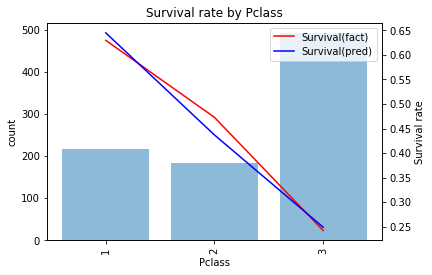

In [14]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [15]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([X_single_train, pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
       mean count
Pclass           
1         1   216
2         0   184
3         0   491

In [16]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-01_pclass.csv', index=False)

# 性別
* 女性なら生存、男性なら死亡と予測するモデル
* accuracy(train): 0.787
* accuracy(test): 0.766
  * testの方が2.1%低い

In [17]:
# ロジスティック回帰モデル
features = ['Sex_female']

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [18]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.787


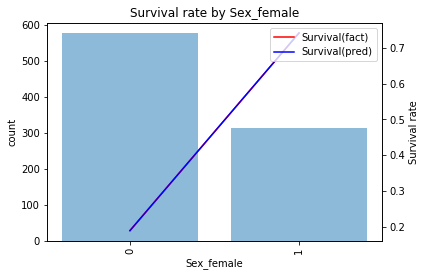

In [19]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [20]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([X_single_train, pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
           mean count
Sex_female           
0             0   577
1             1   314

In [21]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-02_sex.csv', index=False)

# 年齢
* 5才以下と2ndクラス以上の05〜15才を生存、それ以外を死亡と予測するモデル
* accuracy(train): 0.646
* accuracy(test): 0.627
  * testの方が1.9%低い

In [22]:
# ロジスティック回帰モデル
features = []

for col in X_train.columns:
    if 'AgeCtgr_' in col:
        features.append(col)

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [23]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.646


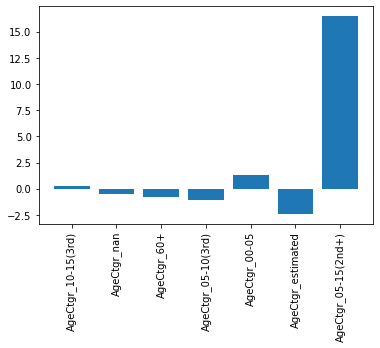

In [24]:
# モデル係数を確認
plot_model_coefficient(model, X_single_train.columns)

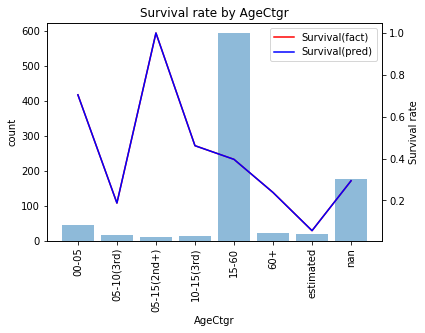

In [25]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, 'AgeCtgr', X_single_train, titanic_all[train_flg], y_train)

In [26]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([titanic_all[train_flg]['AgeCtgr'], pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby('AgeCtgr').agg({'pred': ['mean', 'count']})

pred      
            mean count
AgeCtgr               
00-05          1    44
05-10(3rd)     0    16
05-15(2nd+)    1     9
10-15(3rd)     0    13
15-60          0   593
60+            0    21
estimated      0    18
nan            0   177

In [27]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-03_age.csv', index=False)

# 一緒に乗船した兄弟、配偶者の数(SibSp)
* SibSp=1のみ生存と予測するモデル
* accuracy(train): 0.633
* accuracy(test): 0.617
  * testの方が1.6%低い

In [28]:
# ロジスティック回帰モデル
features = ['SibSp_rounded', 'SibSp=0']

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [29]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.633


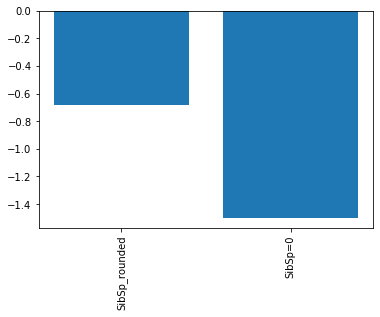

In [30]:
# モデル係数を確認
plot_model_coefficient(model, X_single_train.columns)

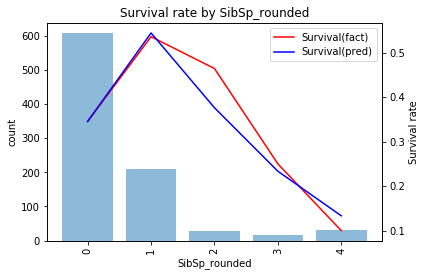

In [31]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [32]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([X_single_train, pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
                      mean count
SibSp_rounded SibSp=0           
0             1          0   608
1             0          1   209
2             0          0    28
3             0          0    16
4             0          0    30

In [33]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-04_SibSp.csv', index=False)

# 一緒に乗船した親子の数(Parch)
* Parch=1のみ生存と予測するモデル
* accuracy(train): 0.630
* accuracy(test): 0.675
  * testの方が4.5%高い

In [34]:
# ロジスティック回帰モデル
features = ['Parch_rounded', 'Parch=0']

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [35]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.630


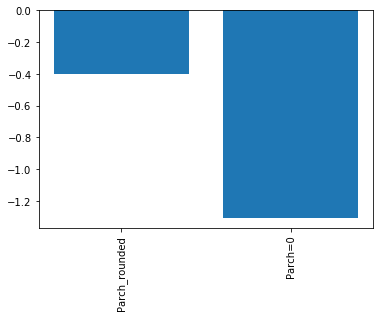

In [36]:
# モデル係数を確認
plot_model_coefficient(model, X_single_train.columns)

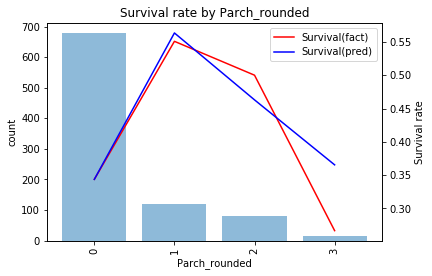

In [37]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [38]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([X_single_train, pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
                      mean count
Parch_rounded Parch=0           
0             1          0   678
1             0          1   118
2             0          0    80
3             0          0    15

In [39]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-05_Parch.csv', index=False)

# 運賃(Fare)
* 46.9以上を生存と予測するモデル
* accuracy(train): 0.673
* accuracy(test): 0.646
  * testの方が2.7%低い

In [40]:
# ロジスティック回帰モデル
features = ['Fare_rounded']

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [41]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.673


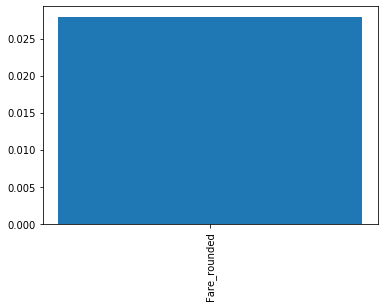

In [42]:
# モデル係数を確認
plot_model_coefficient(model, X_single_train.columns)

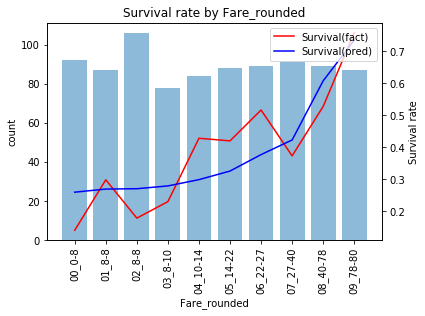

In [43]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [44]:
# 学習結果(生存フラグ)の確認
fare_bin = get_binned_data(X_single_train['Fare_rounded'])
fitting_df = pd.DataFrame({'Fare_rounded': fare_bin,'pred': y_pred})
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
                 mean count
Fare_rounded               
00_0-8        0.00000    92
01_8-8        0.00000    87
02_8-8        0.00000   106
03_8-10       0.00000    78
04_10-14      0.00000    84
05_14-22      0.00000    88
06_22-27      0.00000    89
07_27-40      0.00000    91
08_40-78      0.94382    89
09_78-80      1.00000    87

In [45]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-06_Fare.csv', index=False)

# 乗船港(Embarked)
* Embarked=Cのみ生存と予測するモデル
* accuracy(train): 0.636
* accuracy(test): 0.636

In [46]:
# ロジスティック回帰モデル
features = []

for col in X_train.columns:
    if 'Embarked_' in col:
        features.append(col)

X_single_train = X_train[features]
X_single_test = X_test[features]

model = LogisticRegression(solver='lbfgs', penalty='none')
model.fit(X_single_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='none',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [47]:
# 精度（学習データ全体）
y_pred = model.predict(X_single_train)
accuracy = accuracy_score(y_train, y_pred)

print('* accuracy(train): {:.3f}'.format(accuracy))

* accuracy(train): 0.636


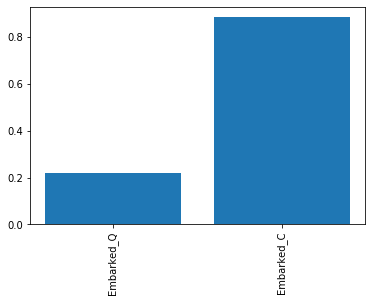

In [48]:
# モデル係数を確認
plot_model_coefficient(model, X_single_train.columns)

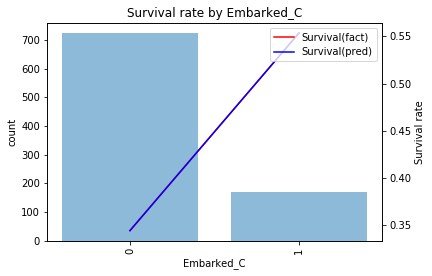

In [49]:
# 学習結果(予測確率)の確認
plot_single_regression_result(model, features[0], X_single_train, X_train, y_train)

In [50]:
# 学習結果(生存フラグ)の確認
fitting_df = pd.concat([X_single_train, pd.DataFrame({'pred': y_pred})], axis=1)
fitting_df.groupby(features).agg({'pred': ['mean', 'count']})

pred      
                      mean count
Embarked_C Embarked_Q           
0          0             0   646
           1             0    77
1          0             1   168

In [51]:
# 予測結果を出力する
y_pred = model.predict(X_single_test)
y_pred = pd.DataFrame({'PassengerId': titanic_test['PassengerId'], 'Survived': y_pred})
y_pred.to_csv('./result/11-07_Embarked.csv', index=False)

# まとめ

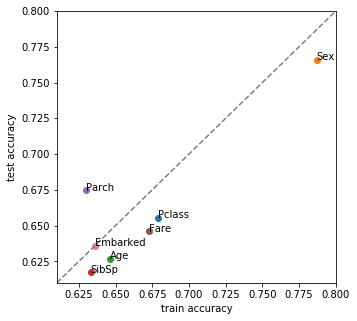

In [52]:
train_test_result = {}

train_test_result['Pclass'] = (0.679, 0.6555)
train_test_result['Sex'] = (0.787, 0.76555)
train_test_result['Age'] = (0.646, 0.62679)
train_test_result['SibSp'] = (0.633, 0.61722)
train_test_result['Parch'] = (0.630, 0.67464)
train_test_result['Fare'] = (0.673, 0.64593)
train_test_result['Embarked'] = (0.636, 0.636)

plt.figure(figsize=(5, 5))

for label, acc in train_test_result.items():
    plt.plot(acc[0], acc[1], marker='o')
    plt.annotate(label, xy=acc)

plt.xlim([0.61, 0.80])
plt.ylim([0.61, 0.80])

plt.xlabel('train accuracy')
plt.ylabel('test accuracy')

x = np.linspace(0.61, 0.80, 3)
y = x

plt.plot(x, y, linestyle='dashed')